# HSCT survival data exploration

## Notebook set-up

In [1]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

import configuration as config

# Load Kaggle login credentials from env
if Path(f'{config.PROJECT_ROOT_PATH}/.env').is_file():
    load_dotenv()

else:
    print(f'Put your Kaggle credentials in {config.PROJECT_ROOT_PATH}/.env')

# Create data directory if needed
Path(f'{config.DATA_PATH}/raw').mkdir(parents=True, exist_ok=True)

# Feature info files
feature_types_dict_file='../data/processed/01.1-feature_type_dict.pkl'
feature_value_translation_dicts_file='../data/processed/01.1-feature_value_translation_dicts.pkl'
nan_placeholders_dict_file='../data/processed/01.1-nan_placeholders_list.pkl'

## 1. Data download

In [2]:
! kaggle competitions download -c equity-post-HCT-survival-predictions -p ../data/raw
! cd ../data/raw && unzip -n ./equity-post-HCT-survival-predictions.zip

equity-post-HCT-survival-predictions.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./equity-post-HCT-survival-predictions.zip


## 2. Datasets
### 2.1. Data dictionary

In [3]:
dictionary_df=pd.read_csv(f'{config.DATA_PATH}/raw/data_dictionary.csv')
dictionary_df.head(len(dictionary_df))

,variable,description,type,values
0,dri_score,Refined disease risk index,Categorical,['Intermediate' 'High' 'N/A - non-malignant in...
1,psych_disturb,Psychiatric disturbance,Categorical,['Yes' 'No' nan 'Not done']
2,cyto_score,Cytogenetic score,Categorical,['Intermediate' 'Favorable' 'Poor' 'TBD' nan '...
3,diabetes,Diabetes,Categorical,['No' 'Yes' nan 'Not done']
4,hla_match_c_high,Recipient / 1st donor allele level (high resol...,Numerical,NaN
5,hla_high_res_8,Recipient / 1st donor allele-level (high resol...,Numerical,NaN
6,tbi_status,TBI,Categorical,"['No TBI' 'TBI + Cy +- Other' 'TBI +- Other, <..."
7,arrhythmia,Arrhythmia,Categorical,['No' nan 'Yes' 'Not done']
8,hla_low_res_6,Recipient / 1st donor antigen-level (low resol...,Numerical,NaN
9,graft_type,Graft type,Categorical,['Peripheral blood' 'Bone marrow']


### 2.2. Training features

In [4]:
training_df=pd.read_csv(f'{config.DATA_PATH}/raw/train.csv')
training_df.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [5]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [6]:
training_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,28800.0,14399.500000,8313.988213,0.000,7199.75000,14399.5000,21599.25000,28799.000
hla_match_c_high,24180.0,1.764516,0.431941,0.000,2.00000,2.0000,2.00000,2.000
hla_high_res_8,22971.0,6.876801,1.564313,2.000,6.00000,8.0000,8.00000,8.000
hla_low_res_6,25530.0,5.143322,1.207757,2.000,4.00000,6.0000,6.00000,6.000
hla_high_res_6,23516.0,5.109202,1.214162,0.000,4.00000,6.0000,6.00000,6.000
hla_high_res_10,21637.0,8.617230,1.905125,3.000,7.00000,10.0000,10.00000,10.000
hla_match_dqb1_high,23601.0,1.736876,0.447687,0.000,1.00000,2.0000,2.00000,2.000
hla_nmdp_6,24603.0,5.160346,1.203240,2.000,4.00000,6.0000,6.00000,6.000
hla_match_c_low,26000.0,1.757808,0.435453,0.000,2.00000,2.0000,2.00000,2.000
hla_match_drb1_low,26157.0,1.715296,0.451282,1.000,1.00000,2.0000,2.00000,2.000


### 2.2. Training labels

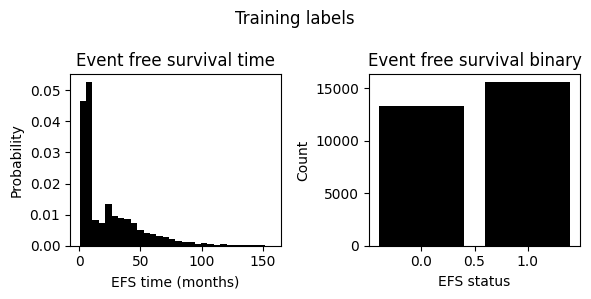

In [7]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(6,3))
axs=axs.flatten()

fig.suptitle('Training labels')

axs[0].set_title('Event free survival time')
axs[0].hist(training_df['efs_time'], density=True, bins=30, color='black')
axs[0].set_xlabel('EFS time (months)')
axs[0].set_ylabel('Probability')

axs[1].set_title('Event free survival binary')
axs[1].bar(training_df['efs'].value_counts().index, training_df['efs'].value_counts(), color='black')
axs[1].set_xlabel('EFS status')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### 2.3. Testing features

In [8]:
testing_df=pd.read_csv(f'{config.DATA_PATH}/raw/test.csv')
testing_df.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,28800,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,28802,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


In [9]:
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 58 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      3 non-null      int64  
 1   dri_score               3 non-null      object 
 2   psych_disturb           3 non-null      object 
 3   cyto_score              1 non-null      object 
 4   diabetes                3 non-null      object 
 5   hla_match_c_high        2 non-null      float64
 6   hla_high_res_8          2 non-null      float64
 7   tbi_status              3 non-null      object 
 8   arrhythmia              3 non-null      object 
 9   hla_low_res_6           3 non-null      float64
 10  graft_type              3 non-null      object 
 11  vent_hist               3 non-null      object 
 12  renal_issue             3 non-null      object 
 13  pulm_severe             3 non-null      object 
 14  prim_disease_hct        3 non-null      object

## 3. Features

### 3.1. Numerical features

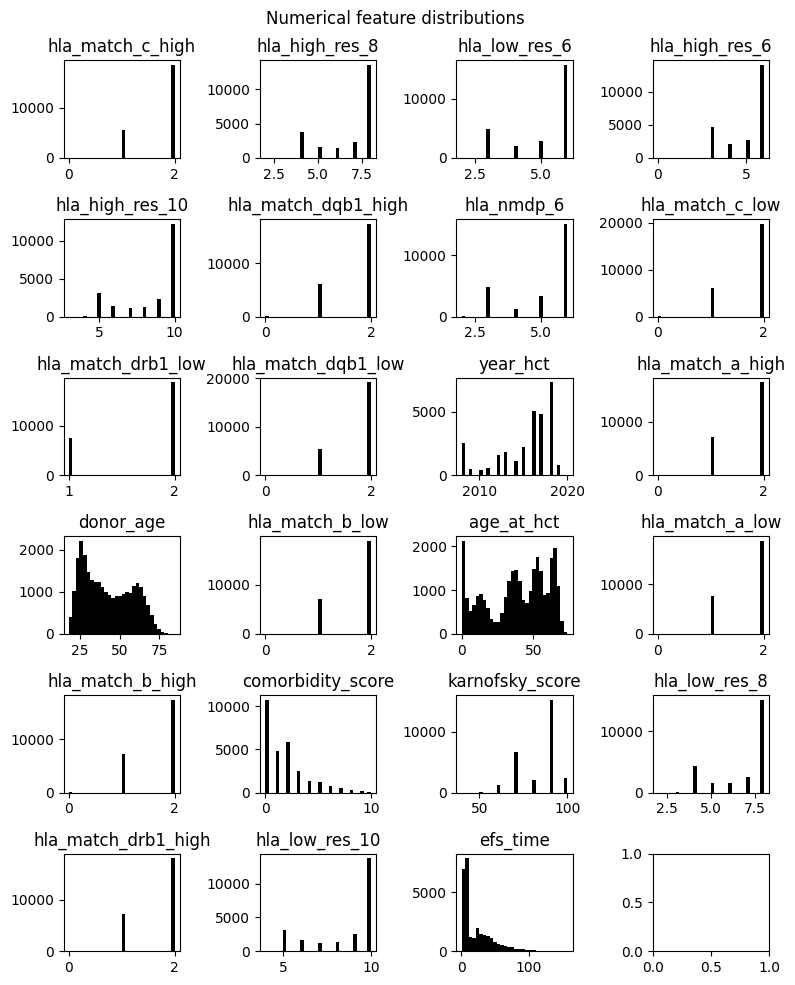

In [10]:
# Extract 'numerical' features as listed in the data dictionary
numerical_feature_names=dictionary_df['variable'][dictionary_df['type'] == 'Numerical']
numerical_features_df=training_df[numerical_feature_names]

# Set-up a 5x5 figure
fig, axs=plt.subplots(6,4, figsize=(8,10))
axs=axs.flatten()

fig.suptitle('Numerical feature distributions')

# Plot each feature
for ax, feature in zip(axs, numerical_features_df.columns):
    ax.set_title(feature)
    ax.hist(numerical_features_df[feature], bins=30, color='black')

plt.tight_layout()
plt.show()

In [11]:
numerical_features=['donor_age', 'age_at_hct', 'year_hct', 'efs_time']
ordinal_numerical_features=[x for x in numerical_features_df.columns if x not in numerical_features]

print(f'True numerical features: {numerical_features}\n')
print(f'Ordinal numerical features: {ordinal_numerical_features}')

True numerical features: ['donor_age', 'age_at_hct', 'year_hct', 'efs_time']

Ordinal numerical features: ['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10']


### 3.2. Categorical features

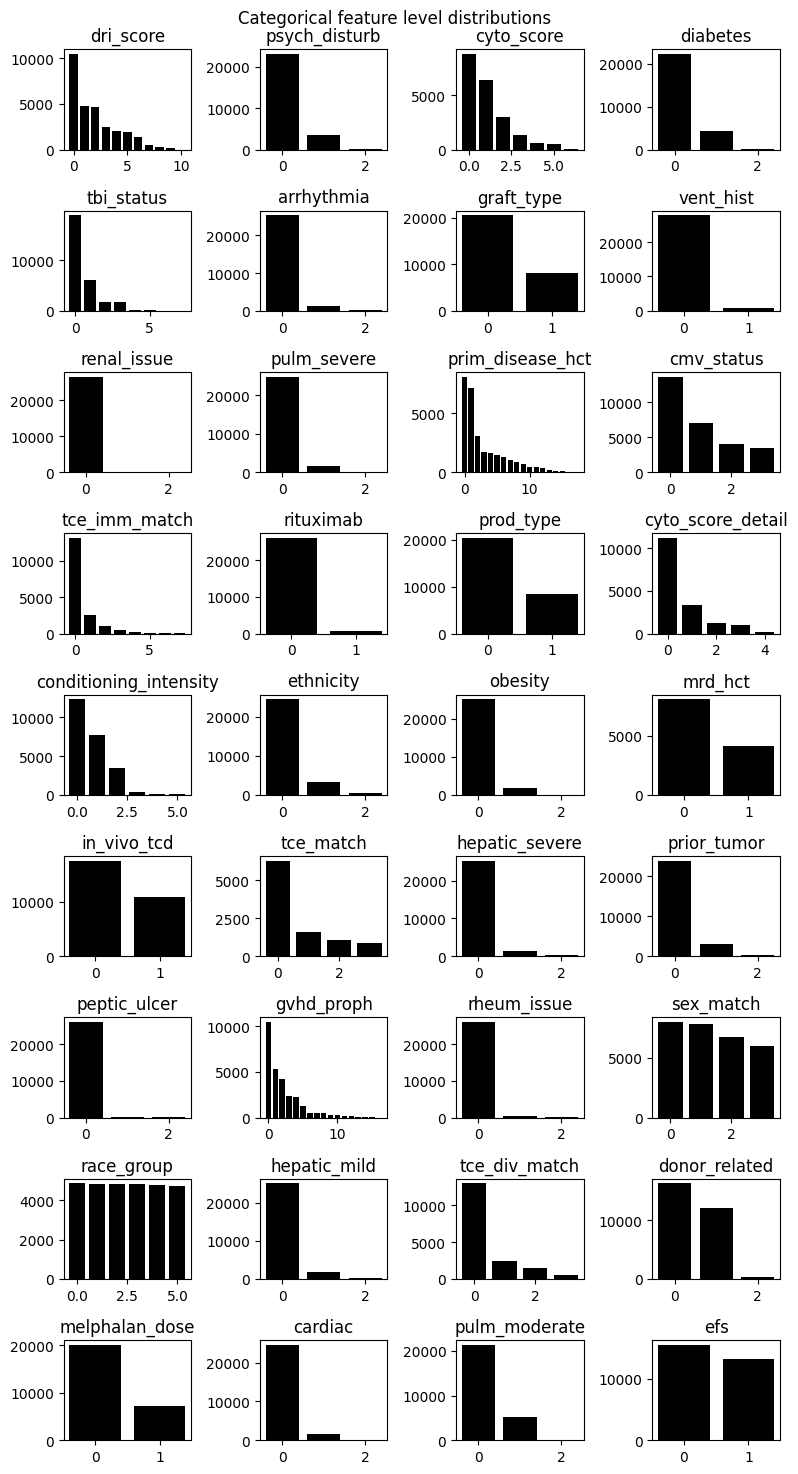

In [12]:
# Extract categorical features as listed in the data dictionary
categorical_feature_names=dictionary_df['variable'][dictionary_df['type'] == 'Categorical']
categorical_features_df=training_df[categorical_feature_names]

# Set-up a 5x5 figure
fig, axs=plt.subplots(9,4, figsize=(8,15))
axs=axs.flatten()

fig.suptitle('Categorical feature level distributions')

# Plot each feature
for ax, feature in zip(axs, categorical_features_df.columns):
    level_counts=categorical_features_df[feature].value_counts()
    ax.set_title(feature)
    ax.bar(list(range(len(level_counts.index))), level_counts.values, color='black')

plt.tight_layout()
plt.show()

#### 3.2.1. Ordinal features

In [13]:
ordinal_categorical_features=['dri_score', 'cyto_score', 'cmv_status', 'cyto_score_detail']
true_categorical_features=[x for x in categorical_features_df.columns if x not in ordinal_categorical_features]
print(f'Ordinal categorical features: {ordinal_categorical_features}\n')
print(f'True categorical features: {true_categorical_features}\n')

Ordinal categorical features: ['dri_score', 'cyto_score', 'cmv_status', 'cyto_score_detail']

True categorical features: ['psych_disturb', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'tce_imm_match', 'rituximab', 'prod_type', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate', 'efs']



##### 3.2.1.1. DRI score

In [14]:
categorical_features_df['dri_score'].value_counts()

dri_score
Intermediate                                         10436
N/A - pediatric                                       4779
High                                                  4701
N/A - non-malignant indication                        2427
TBD cytogenetics                                      2003
Low                                                   1926
High - TED AML case <missing cytogenetics             1414
Intermediate - TED AML case <missing cytogenetics      481
N/A - disease not classifiable                         272
Very high                                              198
Missing disease status                                   9
Name: count, dtype: int64

In [15]:
dri_scores={
    'Intermediate': 2,
    'N/A - pediatric': 0,
    'High': 4,
    'N/A - non-malignant indication': 0,
    'TBD cytogenetics': np.nan,
    'Low': 1,
    'High - TED AML case <missing cytogenetics': 4,
    'Intermediate - TED AML case <missing cytogenetics': 3,
    'N/A - disease not classifiable': np.nan,
    'Very high': 5,
    'Missing disease status': np.nan
}

##### 3.2.1.2. Cyto score

In [16]:
categorical_features_df['cyto_score'].value_counts()

cyto_score
Poor            8802
Intermediate    6376
Favorable       3011
TBD             1341
Normal           643
Other            504
Not tested        55
Name: count, dtype: int64

In [17]:
cyto_scores={
    'Poor': 4,
    'Intermediate': 3, 
    'Favorable': 1,
    'TBD': np.nan,
    'Normal': 2,
    'Other': 0 ,
    'Not tested': np.nan  
}

##### 3.2.1.3. CMV status

In [18]:
categorical_features_df['cmv_status'].value_counts()

cmv_status
+/+    13596
-/+     7081
+/-     4048
-/-     3441
Name: count, dtype: int64

In [19]:
cmv_statuses={
    '+/+': 3,
    '-/+': 1,
    '+/-': 1,
    '-/-': 0
}

##### 3.2.1.4. Cyto score detail

In [20]:
categorical_features_df['cyto_score_detail'].value_counts()

cyto_score_detail
Intermediate    11158
Poor             3323
Favorable        1208
TBD              1043
Not tested        145
Name: count, dtype: int64

In [21]:
cyto_scores_detail={
    'Intermediate': 1,
    'Poor': 2,
    'Favorable': 0,
    'TBD': np.nan,
    'Not tested': np.nan,
}

#### 3.2.2. Other missing values

In [22]:
missing_values={
    'Not done': np.nan,
    'TBD': np.nan,
    'Not tested': np.nan,
    'N/A': np.nan
}

with open(nan_placeholders_dict_file, 'wb') as output_file:
    pickle.dump(missing_values, output_file)

### 3.3. Feature dictionaries

In [23]:
feature_types={
    'True numerical features': numerical_features,
    'Ordinal numerical features': ordinal_numerical_features,
    'Ordinal categorical features': ordinal_categorical_features,
    'True categorical features': true_categorical_features
}

with open(feature_types_dict_file, 'wb') as output_file:
    pickle.dump(feature_types, output_file)

feature_value_translation_dicts={
    'dri_score': dri_scores,
    'cyto_score': cyto_scores,
    'cmv_status': cmv_statuses,
    'cyto_scores_detail': cyto_scores_detail
}

with open(feature_value_translation_dicts_file, 'wb') as output_file:
    pickle.dump(feature_value_translation_dicts, output_file)

## 4. NAN distribution

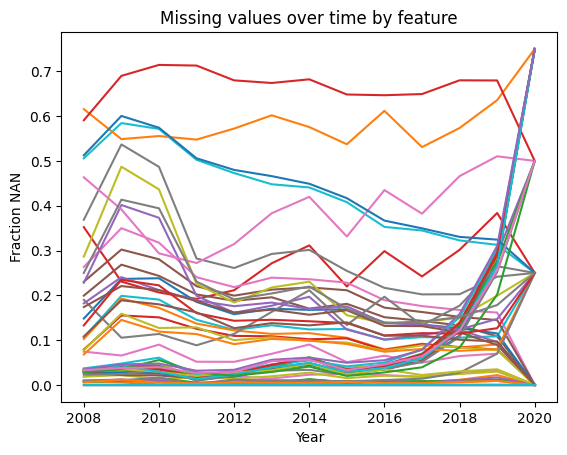

In [24]:
nan_counts=training_df.groupby('year_hct')[training_df.columns].apply(lambda x: x.isna().sum())
row_counts=training_df.groupby('year_hct')[training_df.columns].apply(lambda x: len(x))

plt.title('Missing values over time by feature')

for feature in nan_counts.columns:
    plt.plot(row_counts.index, nan_counts[feature]/row_counts)

plt.xlabel('Year')
plt.ylabel('Fraction NAN')
plt.show()